# Problem 2
Approach: Using the same data as in problem 1, here we predict whether high demand will occur within 7 days. To determine demand for next 7 days , we use a sliding window of 7 days to compute the total demand ~ sum of count for the next 7 days. To this, the training and test dataset is also reconstructed such that each record corresponds to a day (vs an hourly record in problem 1).

# Import libraries

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 30)

#sns.set_style("whitegrid")
#plt.style.use('bmh')
plt.style.use('seaborn-whitegrid')

# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Prepare the training and the test datasets
Here the hourly records within the datasets have been rolled up to construct a record per day. To be able to do this, real variables such as temp, atemp, humidity, windspeed for the day is the daily mean. And the count for the day is the sum of counts for each hour of each day.

In [122]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
all_df = pd.concat([train_df, test_df])

dt = pd.DatetimeIndex(all_df['datetime'])
all_df.set_index(dt, inplace=True)
all_df['date'] = dt.date
all_df['day'] = dt.day
all_df['month'] = dt.month
all_df['year'] = dt.year
all_df['hour'] = dt.hour
all_df['dow'] = dt.dayofweek
all_df['woy'] = dt.weekofyear
all_df.head(5)

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\1442127833.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  all_df['woy'] = dt.weekofyear


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,day,month,year,hour,dow,woy
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1/01/2011 0:00,1,0,0,1,0.24,0.2879,0.81,0.0,16.0,2011-01-01,1,1,2011,0,5,52
2011-01-01 01:00:00,1/01/2011 1:00,1,0,0,1,0.22,0.2727,0.80,0.0,40.0,2011-01-01,1,1,2011,1,5,52
2011-01-01 02:00:00,1/01/2011 2:00,1,0,0,1,0.22,0.2727,0.80,0.0,32.0,2011-01-01,1,1,2011,2,5,52
2011-01-01 03:00:00,1/01/2011 3:00,1,0,0,1,0.24,0.2879,0.75,0.0,13.0,2011-01-01,1,1,2011,3,5,52
2011-01-01 04:00:00,1/01/2011 4:00,1,0,0,1,0.24,0.2879,0.75,0.0,1.0,2011-01-01,1,1,2011,4,5,52


In [125]:
date_x = "2011-01-01"
day_count = 0
day_temp = 0
day_atemp = 0
day_humidity = 0
day_windspeed = 0
num = 0.1

new_train = pd.DataFrame()
for i, j in all_df.iterrows():

    #print(date_x, j['date'], j['count'], day_count)
    
    if date_x == j['date']:
        day_count = day_count+j['count'] 
        day_temp = day_temp+j['temp']
        day_atemp = day_atemp+j['atemp']
        day_humidity = day_humidity+j['humidity']
        day_windspeed = day_windspeed+j['windspeed']              
        num = num+1
    else:
        new_row = {'date':date_x,'day_count':day_count,'day_temp':day_temp/num,'day_atemp':day_atemp/num,
                   'day_humidity':day_humidity/num,'day_windspeed':day_windspeed/num}
        new_train = new_train.append(new_row,ignore_index = True)
        #print("new row added", new_row)
        date_x = j['date']
        day_count = 0
        day_temp = 0
        day_atemp = 0
        day_humidity = 0
        day_windspeed = 0
        num = 0.1

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train = new_train.append(new_row,ignore_index = True)
C:\Users\Shameek\AppData\Local\Temp\ipykernel_24920\817622101.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train 

In [126]:
# printing the new training dataset : new_train
new_train.head(5)

,date,day_count,day_temp,day_atemp,day_humidity,day_windspeed
0,2011-01-01,0.0,0.000000,0.000000,0.000000,0.000000
1,2011-01-01,969.0,0.347186,0.365329,NaN,0.166697
2,2011-02-01,784.0,0.357466,0.347579,0.684615,0.245154
3,2011-03-01,1344.0,0.194313,0.188147,NaN,0.241924
4,2011-04-01,1557.0,0.200905,0.212534,0.589593,0.162095


# Establishing demand categories

In [113]:
demand_max = new_train['day_count'].max()
demand_min = new_train['day_count'].min()
demand_avg = new_train['day_count'].mean()
print("Maximum daily demand:",demand_max)
print("Minimum daily demand:",demand_min)
print("Mean daily demand:",demand_avg)

Maximum daily demand: 8507.0
Minimum daily demand: 0.0
Mean daily demand: 4475.292817679558


Text(0.5, 1.0, 'Day Vs Number of bikes rented')

Text(0.5, 0, 'Day')

Text(0, 0.5, 'Number of bikes rented')

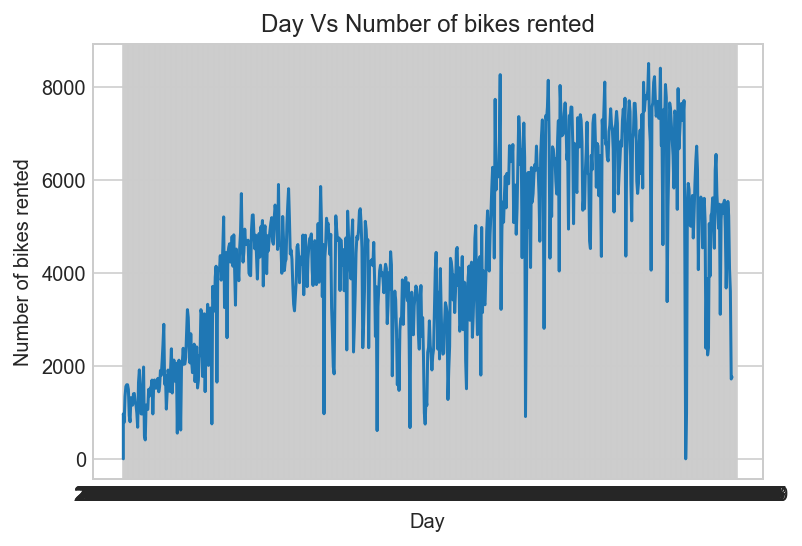

In [92]:
new_train['date']=new_train['date'].astype(str)
plt.plot(new_train['date'], new_train['day_count'])
plt.title('Day Vs Number of bikes rented')
plt.xlabel('Day')
plt.ylabel('Number of bikes rented')
plt.show()

In [127]:
new_train = new_train.loc[1:,:]
new_train['weekly_demand'] = 0
for i, j in new_train.iterrows():
        sum_7days = new_train.loc[i:(i+7),'day_count'].sum()
        new_train.loc[i,'weekly_demand'] = sum_7days


In [128]:
new_train['weekly_demand']

1      10270
2      10098
3      10630
4      10537
5      10135
       ...  
725        0
726        0
727        0
728        0
729        0
Name: weekly_demand, Length: 729, dtype: int64

Text(0.5, 1.0, 'Day Vs Demand for next 7 days')

Text(0.5, 0, 'Day')

Text(0, 0.5, 'Demand for next 7 days')

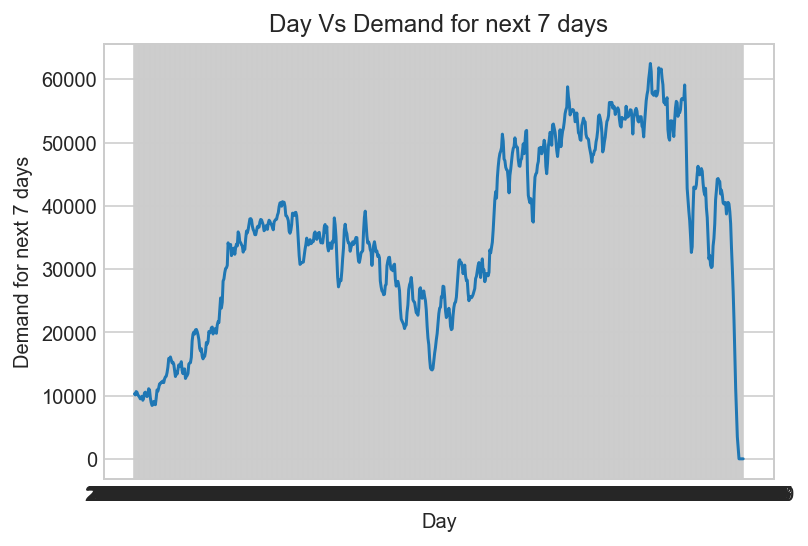

In [100]:
new_train['date']=new_train['date'].astype(str)
plt.plot(new_train['date'], new_train['weekly_demand'])
plt.title('Day Vs Demand for next 7 days')
plt.xlabel('Day')
plt.ylabel('Demand for next 7 days')
plt.show()

In [101]:
week_demand_max = new_train['weekly_demand'].max()
week_demand_min = new_train['weekly_demand'].min()
week_demand_avg = new_train['weekly_demand'].mean()
print("Maximum weekly demand:",week_demand_max)
print("Minimum weekly demand:",week_demand_min)
print("Mean weekly demand:",week_demand_avg)

Maximum weekly demand: 62501
Minimum weekly demand: 0
Mean weekly demand: 35510.28257887517


As seen from the metrics, the mean weekly demand of bikes in a week ~ 35474. Let us consider, >40000 as high demand as also shown by the demand plot. 

In [129]:
new_train.head(5)

,date,day_count,day_temp,day_atemp,day_humidity,day_windspeed,weekly_demand
1,2011-01-01,969.0,0.347186,0.365329,NaN,0.166697,10270
2,2011-02-01,784.0,0.357466,0.347579,0.684615,0.245154,10098
3,2011-03-01,1344.0,0.194313,0.188147,NaN,0.241924,10630
4,2011-04-01,1557.0,0.200905,0.212534,0.589593,0.162095,10537
5,2011-05-01,1594.0,0.227149,0.226950,NaN,0.194511,10135


In [130]:
train_X = new_train[['date','day_count','day_temp','day_atemp','day_humidity','day_windspeed','weekly_demand']]
test_X = train_X[train_X["weekly_demand"] == 0]
train_X = train_X[train_X["weekly_demand"] != 0]

print(train_X.shape)
print(test_X.shape)

train_X.head(5)
test_X.head(5)


(723, 7)
(6, 7)


,date,day_count,day_temp,day_atemp,day_humidity,day_windspeed,weekly_demand
1,2011-01-01,969.0,0.347186,0.365329,NaN,0.166697,10270
2,2011-02-01,784.0,0.357466,0.347579,0.684615,0.245154,10098
3,2011-03-01,1344.0,0.194313,0.188147,NaN,0.241924,10630
4,2011-04-01,1557.0,0.200905,0.212534,0.589593,0.162095,10537
5,2011-05-01,1594.0,0.227149,0.226950,NaN,0.194511,10135


,date,day_count,day_temp,day_atemp,day_humidity,day_windspeed,weekly_demand
724,2012-12-24,NaN,0.230769,0.257104,0.792308,0.080376,0
725,2012-12-25,NaN,0.292308,0.294801,0.722624,0.171543,0
726,2012-12-26,NaN,0.240693,0.217113,0.827273,0.317896,0
727,2012-12-27,NaN,0.252814,0.225632,0.640693,0.350853,0
728,2012-12-28,NaN,0.252814,0.254489,0.587013,0.154420,0


In [131]:
train_X.dropna()

,date,day_count,day_temp,day_atemp,day_humidity,day_windspeed,weekly_demand
2,2011-02-01,784.0,0.357466,0.347579,0.684615,0.245154,10098
4,2011-04-01,1557.0,0.200905,0.212534,0.589593,0.162095,10537
6,2011-06-01,1595.0,0.204525,0.231738,0.514480,0.093213,9940
7,2011-07-01,1493.0,0.195475,0.208430,0.490045,0.166819,9752
9,2011-09-01,797.0,0.139394,0.117420,0.432900,0.359251,9710
...,...,...,...,...,...,...,...
719,2012-12-19,5226.0,0.332468,0.341719,0.623377,0.191264,16396
720,2012-12-20,4086.0,0.329004,0.333848,0.667532,0.131810,11170
721,2012-12-21,3606.0,0.321212,0.295160,0.540260,0.376048,7084
722,2012-12-22,1718.0,0.264935,0.236130,0.439394,0.398017,3478


In [134]:
train_X = train_X.dropna()
X = train_X.drop(['day_count','date','weekly_demand'], axis=1)
y = train_X['weekly_demand']

X_test = test_X.drop(['day_count','date','weekly_demand'], axis=1)
y_test = test_X['weekly_demand']

X.head(5)
X_test.head(10)

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X, y);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
print("Test predictions are -", predictions)

,day_temp,day_atemp,day_humidity,day_windspeed
2,0.357466,0.347579,0.684615,0.245154
4,0.200905,0.212534,0.589593,0.162095
6,0.204525,0.231738,0.514480,0.093213
7,0.195475,0.208430,0.490045,0.166819
9,0.139394,0.117420,0.432900,0.359251


,day_temp,day_atemp,day_humidity,day_windspeed
724,0.230769,0.257104,0.792308,0.080376
725,0.292308,0.294801,0.722624,0.171543
726,0.240693,0.217113,0.827273,0.317896
727,0.252814,0.225632,0.640693,0.350853
728,0.252814,0.254489,0.587013,0.154420
729,0.252814,0.241351,0.751948,0.129229


RandomForestRegressor(n_estimators=1000, random_state=42)

Test predictions are - [18680.432 28599.802 19555.341 19145.351 17111.055 18935.433]


# Future weekly demand is predicted to be low from 24th Dec 2012.
This is because the mean weekly demand ~35000 and the test predictions for weekly demand indicated less than the mean. 